# CREATING EMBEDDINGS USING NEURAL NETWORK

In [1]:
import pandas as pd
from tqdm import tqdm
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Input, Model
from keras.layers import Dense
from scipy import sparse
from nltk.corpus import brown, movie_reviews, treebank
from gensim.models import Word2Vec


Using TensorFlow backend.
C:\Users\Admin\anaconda3\envs\nlppractice\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## DATA PREPROCESSING

In [2]:
# Helper Functions

# Helper function to preprocess the text
def textPreprocessing(text:list, 
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will'])->list:

    # Removing Punctuations from the dataset
    for i in text.lower():
        if i in punctuations:
            text = text.replace(x, "")
    
    # Removing the words that have numbers in them
    text = re.sub(r"\w*\d\w*", "", text)

    # Removing the numbers from the words
    text = re.sub(r"[0-9]+", "", text)

    # Setting every word to lower
    text = text.lower()
    
    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

# Helper function to create a dictionary of unique words in the text
def uniqueWordDict(text:list)->dict:
    # Gettting the unique words of the text and creating a list of those words
    words = list(set(text))
    words.sort()
    print(words)

    # For those unique words using enumerate creating a dict with unique index for each word
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({word:i})
    print(unique_word_dict)

    return unique_word_dict


In [3]:
sentences = pd.read_csv("emb_input/sample.csv")
sentences = [sentences for sentences in sentences['text']]

In [4]:
sentences

['The future king is the prince',
 'Daughter is the princess ',
 'Son is the prince',
 'Only a man can be a king ',
 'Only a woman can be a queen',
 'The princess will be a queen',
 'Queen and king rule the realm',
 'The prince is a strong man',
 'The princess is a beautiful woman ',
 'The royal family is the king and queen and their children',
 'Prince is only a boy now',
 'A boy will be a man']

In [5]:
word_jump_window = 3

word_list = []
all_text = []

In [6]:
for sentence in sentences:
    text = textPreprocessing(sentence)
    print(text)
    all_text+=text
    # Creating a context dictionary
    for i, word in enumerate(text):
        print(".....Index....." ,i,".....Word.....",word)
        for w in range(word_jump_window):
            # print(len(text))
            # print("i+1+w, len(text)",i+1+w, len(text))
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_list.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_list.append([word] + [text[(i - w - 1)]]) 

['future', 'king', 'prince']
.....Index..... 0 .....Word..... future
.....Index..... 1 .....Word..... king
.....Index..... 2 .....Word..... prince
['daughter', 'princess']
.....Index..... 0 .....Word..... daughter
.....Index..... 1 .....Word..... princess
['son', 'prince']
.....Index..... 0 .....Word..... son
.....Index..... 1 .....Word..... prince
['only', 'man', 'can', 'king']
.....Index..... 0 .....Word..... only
.....Index..... 1 .....Word..... man
.....Index..... 2 .....Word..... can
.....Index..... 3 .....Word..... king
['only', 'woman', 'can', 'queen']
.....Index..... 0 .....Word..... only
.....Index..... 1 .....Word..... woman
.....Index..... 2 .....Word..... can
.....Index..... 3 .....Word..... queen
['princess', 'queen']
.....Index..... 0 .....Word..... princess
.....Index..... 1 .....Word..... queen
['queen', 'king', 'rule', 'realm']
.....Index..... 0 .....Word..... queen
.....Index..... 1 .....Word..... king
.....Index..... 2 .....Word..... rule
.....Index..... 3 .....Word.

In [7]:
len(word_list)

98

In [8]:
print("List of Words:", word_list)
print("------------------------------------------------------------------------------------")
unique_word_dict = uniqueWordDict(all_text)
print("Unique Word Dict", unique_word_dict)

List of Words: [['future', 'king'], ['future', 'prince'], ['king', 'prince'], ['king', 'future'], ['prince', 'king'], ['prince', 'future'], ['daughter', 'princess'], ['princess', 'daughter'], ['son', 'prince'], ['prince', 'son'], ['only', 'man'], ['only', 'can'], ['only', 'king'], ['man', 'can'], ['man', 'only'], ['man', 'king'], ['can', 'king'], ['can', 'man'], ['can', 'only'], ['king', 'can'], ['king', 'man'], ['king', 'only'], ['only', 'woman'], ['only', 'can'], ['only', 'queen'], ['woman', 'can'], ['woman', 'only'], ['woman', 'queen'], ['can', 'queen'], ['can', 'woman'], ['can', 'only'], ['queen', 'can'], ['queen', 'woman'], ['queen', 'only'], ['princess', 'queen'], ['queen', 'princess'], ['queen', 'king'], ['queen', 'rule'], ['queen', 'realm'], ['king', 'rule'], ['king', 'queen'], ['king', 'realm'], ['rule', 'realm'], ['rule', 'king'], ['rule', 'queen'], ['realm', 'rule'], ['realm', 'king'], ['realm', 'queen'], ['prince', 'strong'], ['prince', 'man'], ['strong', 'man'], ['strong',

In [9]:
n_words = len(unique_word_dict)
terms = list(unique_word_dict.keys())
print("List of unique words", terms)

List of unique words ['beautiful', 'boy', 'can', 'children', 'daughter', 'family', 'future', 'king', 'man', 'now', 'only', 'prince', 'princess', 'queen', 'realm', 'royal', 'rule', 'son', 'strong', 'their', 'woman']


In [10]:
X = []
Y = []

In [11]:
for i, wl in tqdm(enumerate(word_list)):
    main_word_index = unique_word_dict.get(wl[0])
    context_word_index = unique_word_dict.get(wl[1])
    X_encode = np.zeros(n_words)
    Y_encode = np.zeros(n_words)
    X_encode[main_word_index] = 1
    Y_encode[context_word_index] = 1
    X.append(X_encode)
    Y.append(Y_encode)

98it [00:00, ?it/s]


In [12]:
print(X)

[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]),

In [13]:
print(Y)

[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0.]),

In [14]:
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)

In [15]:
print(X)

  (0, 6)	1.0
  (1, 6)	1.0
  (2, 7)	1.0
  (3, 7)	1.0
  (4, 11)	1.0
  (5, 11)	1.0
  (6, 4)	1.0
  (7, 12)	1.0
  (8, 17)	1.0
  (9, 11)	1.0
  (10, 10)	1.0
  (11, 10)	1.0
  (12, 10)	1.0
  (13, 8)	1.0
  (14, 8)	1.0
  (15, 8)	1.0
  (16, 2)	1.0
  (17, 2)	1.0
  (18, 2)	1.0
  (19, 7)	1.0
  (20, 7)	1.0
  (21, 7)	1.0
  (22, 10)	1.0
  (23, 10)	1.0
  (24, 10)	1.0
  :	:
  (73, 13)	1.0
  (74, 13)	1.0
  (75, 13)	1.0
  (76, 13)	1.0
  (77, 19)	1.0
  (78, 19)	1.0
  (79, 19)	1.0
  (80, 19)	1.0
  (81, 3)	1.0
  (82, 3)	1.0
  (83, 3)	1.0
  (84, 11)	1.0
  (85, 11)	1.0
  (86, 11)	1.0
  (87, 10)	1.0
  (88, 10)	1.0
  (89, 10)	1.0
  (90, 1)	1.0
  (91, 1)	1.0
  (92, 1)	1.0
  (93, 9)	1.0
  (94, 9)	1.0
  (95, 9)	1.0
  (96, 1)	1.0
  (97, 8)	1.0


In [16]:
print(Y)

  (0, 7)	1.0
  (1, 11)	1.0
  (2, 11)	1.0
  (3, 6)	1.0
  (4, 7)	1.0
  (5, 6)	1.0
  (6, 12)	1.0
  (7, 4)	1.0
  (8, 11)	1.0
  (9, 17)	1.0
  (10, 8)	1.0
  (11, 2)	1.0
  (12, 7)	1.0
  (13, 2)	1.0
  (14, 10)	1.0
  (15, 7)	1.0
  (16, 7)	1.0
  (17, 8)	1.0
  (18, 10)	1.0
  (19, 2)	1.0
  (20, 8)	1.0
  (21, 10)	1.0
  (22, 20)	1.0
  (23, 2)	1.0
  (24, 13)	1.0
  :	:
  (73, 7)	1.0
  (74, 3)	1.0
  (75, 5)	1.0
  (76, 15)	1.0
  (77, 3)	1.0
  (78, 13)	1.0
  (79, 7)	1.0
  (80, 5)	1.0
  (81, 19)	1.0
  (82, 13)	1.0
  (83, 7)	1.0
  (84, 10)	1.0
  (85, 1)	1.0
  (86, 9)	1.0
  (87, 1)	1.0
  (88, 11)	1.0
  (89, 9)	1.0
  (90, 9)	1.0
  (91, 10)	1.0
  (92, 11)	1.0
  (93, 1)	1.0
  (94, 10)	1.0
  (95, 11)	1.0
  (96, 8)	1.0
  (97, 1)	1.0


## MODEL CREATION AND TRAINING

In [17]:
embedding_dim = 2
inp = Input(shape=(X.shape[1],))
x = Dense(units=embedding_dim, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [18]:
model.fit(x=X, y=Y, batch_size=256, epochs=1000)

Epoch 1/1000
98/98 [==============================] - 0s 725us/step - loss: 3.0524
Epoch 2/1000
98/98 [==============================] - 0s 10us/step - loss: 3.0513
Epoch 3/1000
98/98 [==============================] - 0s 20us/step - loss: 3.0503
Epoch 4/1000
98/98 [==============================] - 0s 51us/step - loss: 3.0492
Epoch 5/1000
98/98 [==============================] - 0s 20us/step - loss: 3.0482
Epoch 6/1000
98/98 [==============================] - 0s 20us/step - loss: 3.0471
Epoch 7/1000
98/98 [==============================] - 0s 31us/step - loss: 3.0461
Epoch 8/1000
98/98 [==============================] - 0s 31us/step - loss: 3.0451
Epoch 9/1000
98/98 [==============================] - 0s 20us/step - loss: 3.0440
Epoch 10/1000
98/98 [==============================] - 0s 20us/step - loss: 3.0430
Epoch 11/1000
98/98 [==============================] - 0s 30us/step - loss: 3.0420
Epoch 12/1000
98/98 [==============================] - 0s 20us/step - loss: 3.0410
Epoch 13/100

## EMBEDDINGS GENERATION

In [19]:
weights = model.get_weights()[0]

In [23]:
embedding_dict = {}
for word in terms: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

In [24]:
print(embedding_dict)

{'beautiful': array([-0.9979603,  0.5545923], dtype=float32), 'boy': array([1.3277022, 0.8552932], dtype=float32), 'can': array([0.7791776 , 0.59742737], dtype=float32), 'children': array([ 0.54914784, -1.3851901 ], dtype=float32), 'daughter': array([-1.771444 ,  1.4721028], dtype=float32), 'family': array([ 1.2751046, -0.7519549], dtype=float32), 'future': array([ 1.3570346, -0.9277304], dtype=float32), 'king': array([ 0.46002144, -0.10530383], dtype=float32), 'man': array([0.06515532, 0.6682141 ], dtype=float32), 'now': array([0.83344376, 1.4663641 ], dtype=float32), 'only': array([-0.20818488, -0.3392936 ], dtype=float32), 'prince': array([0.06368334, 1.5178672 ], dtype=float32), 'princess': array([-1.2633272 , -0.75220335], dtype=float32), 'queen': array([-0.130404  , -0.28608635], dtype=float32), 'realm': array([ 0.7558729, -0.6043566], dtype=float32), 'royal': array([ 0.737793  , -0.63941157], dtype=float32), 'rule': array([ 1.0169101, -1.133656 ], dtype=float32), 'son': array([ 

In [25]:
model.get_weights()[0]

array([[-0.9979603 ,  0.5545923 ],
       [ 1.3277022 ,  0.8552932 ],
       [ 0.7791776 ,  0.59742737],
       [ 0.54914784, -1.3851901 ],
       [-1.771444  ,  1.4721028 ],
       [ 1.2751046 , -0.7519549 ],
       [ 1.3570346 , -0.9277304 ],
       [ 0.46002144, -0.10530383],
       [ 0.06515532,  0.6682141 ],
       [ 0.83344376,  1.4663641 ],
       [-0.20818488, -0.3392936 ],
       [ 0.06368334,  1.5178672 ],
       [-1.2633272 , -0.75220335],
       [-0.130404  , -0.28608635],
       [ 0.7558729 , -0.6043566 ],
       [ 0.737793  , -0.63941157],
       [ 1.0169101 , -1.133656  ],
       [ 1.4633101 , -0.500113  ],
       [ 1.4803236 ,  0.17816237],
       [ 0.21358125, -1.2907294 ],
       [-0.95905113,  0.00808531]], dtype=float32)

## EMBEDDINGS VISUALIZATION

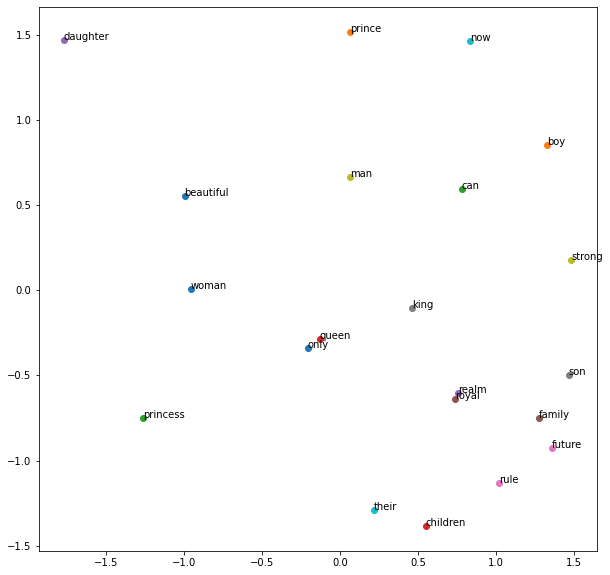

In [26]:
# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))

## SAVING THE EMBEDDINGS

In [29]:
# Saving the embedding vector to a txt file
try:
    os.mkdir(f'{os.getcwd()}\\myoutput')        
except Exception as e:
    print(f'Cannot create output folder: {e}')

with open(f'{os.getcwd()}\\myoutput\\myembedding.txt', 'w') as f:
    for key, value in embedding_dict.items():
        try:
            f.write(f'{key}: {value}\n')   
        except Exception as e:
            print(f'Cannot write word {key} to dict: {e}') 